In [ ]:
import pandas as pd
import numpy as np

import IPython
import IPython.display
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime, timedelta, date

import requests
import json

import glob

In [ ]:
import tensorflow as tf
# tf.random.set_seed(2021)

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Reshape
# from tensorflow.keras.layers import RepeatVector, TimeDistributed, Conv1D, MaxPool1D

# from sklearn.metrics import r2_score

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Wu9pnVytHap9F8t8T9i_a4Bf-0QV6ZNY' -O model_lgb.pkl

!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=17LFISYGBxV6NLKgK5bXih514KX1W4kXO' -O model_lstm_basic_128.zip
!unzip model_lstm_basic_128.zip

--2021-06-19 08:27:49--  https://docs.google.com/uc?export=download&id=1Wu9pnVytHap9F8t8T9i_a4Bf-0QV6ZNY
Resolving docs.google.com (docs.google.com)... 142.250.128.101, 142.250.128.113, 142.250.128.100, ...
Connecting to docs.google.com (docs.google.com)|142.250.128.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-0c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/23l8v5e15upcmrk5jn7e2mcp4uqpi7nh/1624091250000/09102653009714548461/*/1Wu9pnVytHap9F8t8T9i_a4Bf-0QV6ZNY?e=download [following]
--2021-06-19 08:27:50--  https://doc-0s-0c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/23l8v5e15upcmrk5jn7e2mcp4uqpi7nh/1624091250000/09102653009714548461/*/1Wu9pnVytHap9F8t8T9i_a4Bf-0QV6ZNY?e=download
Resolving doc-0s-0c-docs.googleusercontent.com (doc-0s-0c-docs.googleusercontent.com)... 64.233.182.132, 2607:f8b0:4001:c0a::84
Connecting to doc-0s-0c-docs.googleusercontent.com (doc-0s-

In [ ]:
import joblib
model_lgb = joblib.load('model_lgb.pkl')

model_lstm = tf.keras.models.load_model('best_model23')

In [ ]:
day_minus2 = datetime.today() - timedelta(days=2)
today_2hours = datetime.today() + timedelta(hours=2)
forecast_dt = datetime.today() + timedelta(hours=1)

start_dt = datetime(day_minus2.year, day_minus2.month, day_minus2.day, 1, 0)
#end_dt = datetime.today()
end_dt = datetime(today_2hours.year, today_2hours.month, today_2hours.day, today_2hours.hour, 0)

timest = int(datetime.timestamp(day_minus2))

print(start_dt)
print(end_dt)

2021-06-17 01:00:00
2021-06-19 10:00:00


GIOŚ

In [ ]:
# Wokalna - ostatanie dane
gios_wok_dane = json.loads(requests.get('http://api.gios.gov.pl/pjp-api/rest/data/getData/3731').text)
gios_wok = pd.DataFrame(gios_wok_dane['values']) 
gios_wok['date'] = gios_wok['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
gios_wok.rename(columns={"date": "data", "value": "PM25_wok"},inplace=True)


#lista godzin dla których powinny być dane
list_date = []
def daterange(start_date, end_date):
    delta = timedelta(hours=1)
    while start_date < end_date:
        yield start_date
        start_date += delta

for dt in daterange(start_dt, end_dt):
    list_date.append(dt.strftime("%Y-%m-%d %H:%M:%S"))   

#dodanie wartości PM2.5 do dat
df_pm = pd.DataFrame(data = {'data': list_date})
df_pm['data'] = pd.to_datetime(df_pm['data'], format = '%Y-%m-%d %H:%M:%S')
df_pm = pd.merge( df_pm, gios_wok, on=['data'], how='left')

#uzupełnienie ewentualnych błędów
#print('suma brakow: ',df_pm[df_pm.isna().any(axis=1)].shape[0])
print('braki na wokalnej: ', df_pm['PM25_wok'].isna().sum())
df_pm['PM25_wok'].interpolate(limit_direction='both', inplace=True)
#df_pm['hist'] = 1

#print('podgląd początku danych:')
#df_pm.head()

braki na wokalnej:  0


darksky

In [ ]:
#pobieranie danych meteo
keydarksky = '7ac3697dfdc6287097559fdea6546b99'

darksky_hour = []
for i in range(5):
    darksky = json.loads(requests.get('https://api.darksky.net/forecast/{}/52.2193,21.0047,{}?units=si'.format(keydarksky, timest)).text)
    darksky_hour.extend(darksky['hourly']['data'])
    timest += 24*60*60

df_meteo = pd.DataFrame(darksky_hour) 
df_meteo.head()

df_meteo['visibility'] = df_meteo['visibility']/16.093 


#sprawdzenie czy nie ma brakujacych danych
available_var = list(set(df_meteo.columns) - set(['icon','ozone', 'summary', 'time', 'precipType']))
missing_var = list(set(['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity', 
          'precipIntensity', 'pressure', 'temperature', 
          'visibility', 'windBearing', 'windSpeed']) - set(available_var))

print('brakujące zmienne: ', missing_var)

if (len(missing_var)>0):
    for var in missing_var:
        df_meteo[var] = 0


df_meteo['data'] = df_meteo['time'].apply(lambda x: datetime.fromtimestamp(x))
df_meteo['year'] = df_meteo['data'].apply(lambda x: x.year)
df_meteo['month'] = df_meteo['data'].apply(lambda x: x.month)
df_meteo['hour'] = df_meteo['data'].apply(lambda x: x.hour)
df_meteo['day_of_week'] = df_meteo['data'].apply(lambda x: x.isocalendar()[2])


#uzupelnienie braków danych i poprawienie
# interpolacja
cols1=[ 'apparentTemperature', 'cloudCover', 'humidity', # 'precipType', 
      'pressure', 'temperature', 'time',  'visibility', 'windBearing', 'windSpeed']
for col in cols1:
    df_meteo[col].interpolate(limit_direction='both', inplace = True)

# uzupełnienie 0
cols2=['precipIntensity']
for col in cols2:
    df_meteo[col].fillna(0, inplace = True)  

df_meteo.rename(columns={'precipIntensity':'precipitation'},inplace=True)

brakujące zmienne:  []


połączenie danych meteo i pm

In [ ]:
#obserwacje zgodne z GIOS
dane_darksky = df_meteo.loc[df_meteo['data'] >= start_dt].copy()

#zmienne do dalszej obróbki
kolumny = ['data', 'year', 'month', 'hour', 'day_of_week', 'precipitation', 
           'temperature', 'apparentTemperature', 
            'humidity', 'pressure', 'windSpeed',  'windBearing',
            'cloudCover',  'visibility']
dane_darksky = dane_darksky[kolumny].copy()

dane_do_prognoz = pd.merge( dane_darksky, df_pm, on=['data'], how='left')

In [ ]:
danepred = dane_do_prognoz[['PM25_wok',
             'cloudCover', 'humidity', 'precipitation','pressure', 'temperature', 'visibility', 'windBearing', 'windSpeed',
             'month',  'hour', 'day_of_week','data']].copy()

danepred['PM25_wok'] = danepred['PM25_wok'] / 200
danepred['precipitation'] = danepred['precipitation'] / 10
danepred['pressure'] = (danepred['pressure'] - 900) / (1050 - 900)
danepred['temperature'] = (danepred['temperature'] +30) / (40+30)
danepred['visibility'] = danepred['visibility'] / 10
danepred['windBearing'] = danepred['windBearing'] / 359
danepred['windSpeed'] = danepred['windSpeed'] / 20
danepred['month'] = danepred['month'] / 12
#danepred['year'] = (danepred['year'] - 2015) / (2021-2015)
danepred['hour'] = danepred['hour']/23
danepred['day_of_week'] = (danepred['day_of_week'] - 1) / (7-1)


In [ ]:
def wykres():
  dane_przed = danepred.loc[danepred['data'] <= forecast_dt].tail(48).drop(columns=['data'])
  dane_po = danepred.loc[danepred['data'] > forecast_dt].head(24).drop(columns=['PM25_wok','data'])

  ile = len(danepred.loc[danepred['data'] <= forecast_dt])

  y = dane_po.values
  wynik_lgb = model_lgb.predict(y)*200

  tx = tf.convert_to_tensor(dane_przed.values)
  tx = tf.reshape(tx, [1, 48, 12])
  wynik_lstm = model_lstm(tx)*200
  wynik_lstm = tf.reshape(wynik_lstm,[24]).numpy()

  wynik_srednia = [np.mean(dane_przed['PM25_wok'])*200] * 24


  for i in range(ile):
    wynik_lstm = np.insert(wynik_lstm,0,None)
    wynik_lgb = np.insert(wynik_lgb,0,None)
    wynik_srednia = np.insert(wynik_srednia,0,None)

  dane_do_wykresow = dane_do_prognoz.loc[:ile+23,].copy()

  dane_do_wykresow['lgbm'] = wynik_lgb
  dane_do_wykresow['lstm'] = wynik_lstm
  dane_do_wykresow['srednia'] = wynik_srednia
  dane_do_wykresow['lgbm_lstm'] = dane_do_wykresow[['lgbm','lstm']].mean(axis=1)

  plt.figure(figsize=(12,5))
  
  plt.plot(dane_do_wykresow['data'],dane_do_wykresow['PM25_wok'],color='black', label = 'prawdziwe wartości PM2.5', linewidth = 4)
  plt.plot(dane_do_wykresow['data'],dane_do_wykresow['srednia'], color='lightgrey', label = 'średnia z 48h', linewidth = 0.5) 
  plt.plot(dane_do_wykresow['data'],dane_do_wykresow['lgbm_lstm'], color='red', label = 'średnia z LSTM i LightGBM',linestyle='dashed') 
  plt.plot(dane_do_wykresow['data'],dane_do_wykresow['lgbm'], color='blue', label = 'LightGBM') 
  plt.plot(dane_do_wykresow['data'],dane_do_wykresow['lstm'], color='orange', label = 'LSTM') 


  plt.title('prognoza na: ' + end_dt.strftime("%Y-%m-%d %H:%M"))
  plt.legend()
  plt.ylim(top=50)
  plt.show()

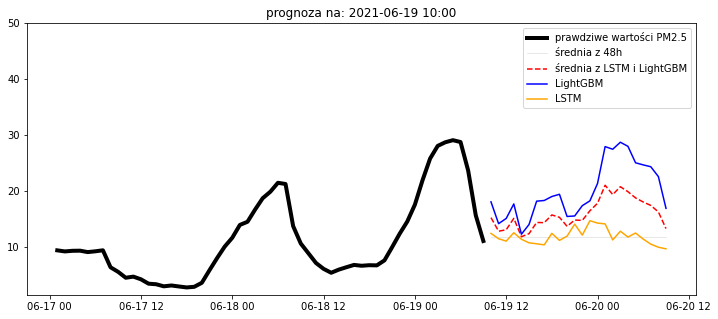

In [ ]:
wykres()

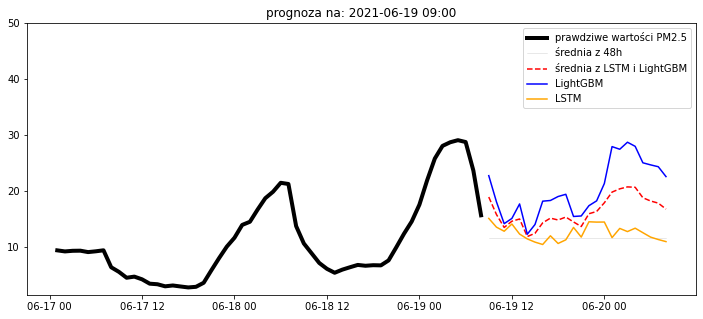

In [ ]:
wykres()

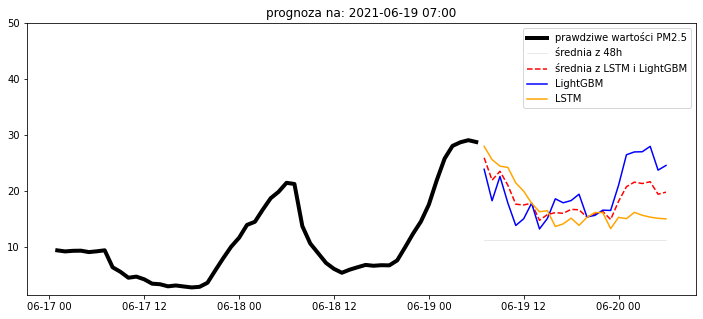

In [ ]:
wykres()

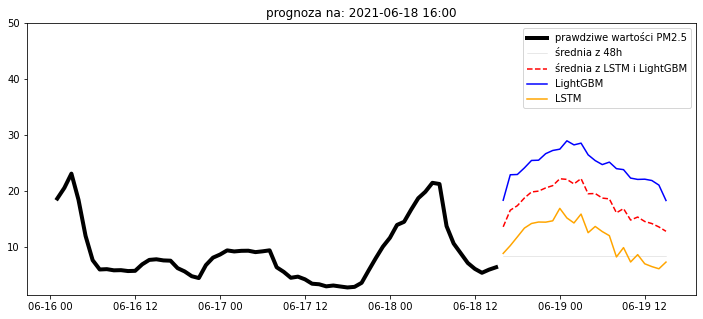

In [ ]:
wykres()

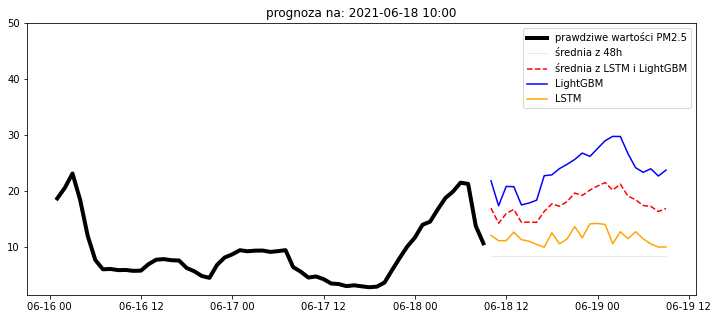

In [ ]:
wykres()

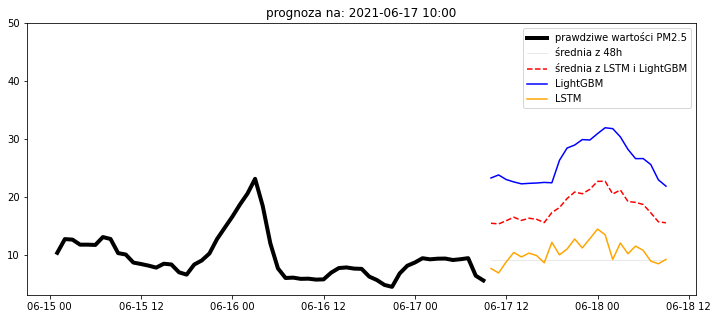

In [ ]:
wykres()

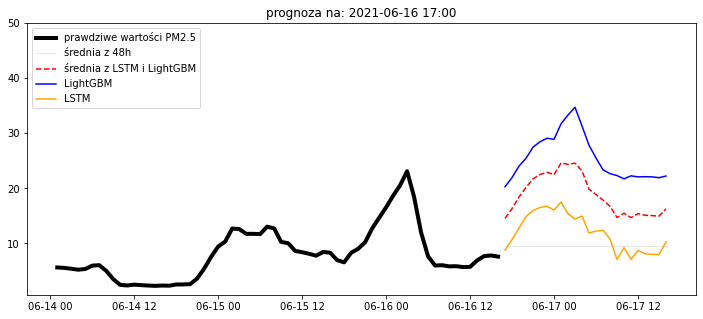

In [ ]:
wykres()

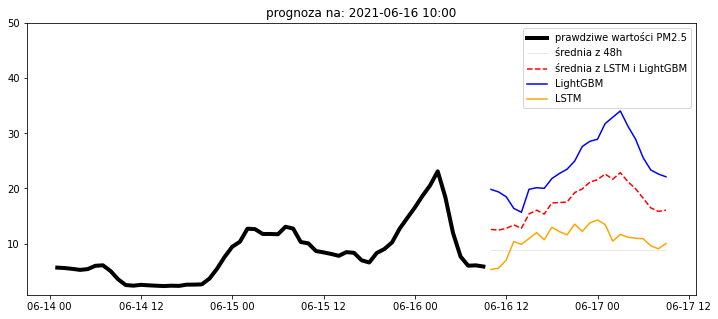

In [ ]:
wykres()

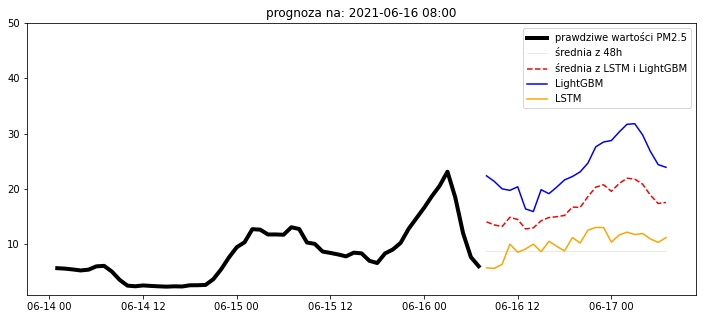

In [ ]:
wykres()

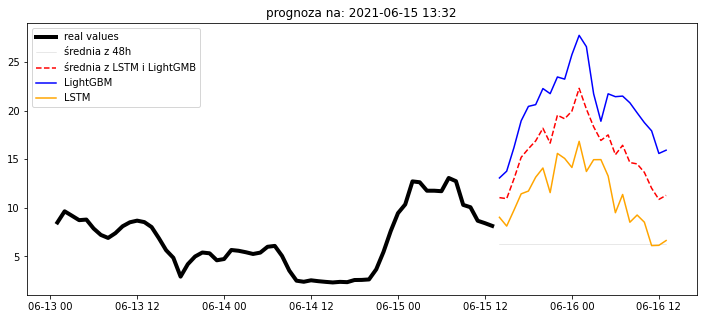

In [ ]:
wykres()